In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math

import geopandas as gpd
import json

from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter
from bokeh.palettes import brewer

from bokeh.io.doc import curdoc
from bokeh.models import Slider, HoverTool, Select
from bokeh.layouts import widgetbox, row, column

In [2]:
def style(p):
    # Title 
    p.title.align = 'center'
    p.title.text_font_size = '20pt'
    p.title.text_font = 'serif'

    # Axis titles
    p.xaxis.axis_label_text_font_size = '14pt'
    p.xaxis.axis_label_text_font_style = 'bold'
    p.yaxis.axis_label_text_font_size = '14pt'
    p.yaxis.axis_label_text_font_style = 'bold'

    # Tick labels
    p.xaxis.major_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'

    return p

In [3]:
df = pd.read_csv('../Data/DC_Properties.csv')
print(df.shape)
df.head(5)

C:\Users\gudmu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18,19,20,21,22,23,24,33,34,35,37,43,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(158957, 49)


,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,...,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT
0,0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,...,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
1,1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,...,-77.040764,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
2,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,...,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
3,3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,...,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
4,4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,...,-77.039361,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW


In [4]:
# Fill house square foot zero values with the average house square footage by bedroom
average_data = df.groupby('BEDRM').LANDAREA.mean()
# Use average landarea by bedroom for each 0 value in each bedroom group, up to 14 bedrooms 
for i in range(0, 14): 
    df.loc[(df['LANDAREA'] == 0) & (df['BEDRM'] == i), 'LANDAREA'] = average_data.loc[i]


In [5]:
# Create a price_sf column
df['price_sf'] = df['PRICE'] / df['LANDAREA']
df.head(5)

,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,...,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,price_sf
0,0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,...,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW,651.785714
1,1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,...,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW,NaN
2,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,...,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW,1250.000000
3,3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,...,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW,953.571429
4,4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,...,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW,NaN


In [6]:
df = df[df['YR_RMDL'].notna()]
df = df[df['ASSESSMENT_NBHD'].notna()]
df = df[df['PRICE'].notna()]
df = df[df['LANDAREA'].notna()]
df = df[df['price_sf'].notna()]
neighborhood_data = df.groupby(
    ['YR_RMDL', 'ASSESSMENT_NBHD', 'CENSUS_TRACT']
).agg(
    {
    'PRICE': ['count', 'mean', 'median'],
    'LANDAREA': ['mean'],
    'price_sf': ['mean']
    }
)

#Reset the index to 1 level to fill in year
neighborhood_data = neighborhood_data.set_axis(neighborhood_data.columns.map('_'.join), axis=1, inplace=False)
neighborhood_data = neighborhood_data.reset_index(level=[0,1])

# Change data types to integer for price_sf and year
neighborhood_data = neighborhood_data.astype({'PRICE_mean': 'int'})
neighborhood_data = neighborhood_data.astype({'PRICE_median': 'int'})
neighborhood_data = neighborhood_data.astype({'LANDAREA_mean': 'int'})
neighborhood_data = neighborhood_data.astype({'price_sf_mean': 'int'})
neighborhood_data = neighborhood_data.astype({'YR_RMDL': 'int'})

neighborhood_data.head()

,YR_RMDL,ASSESSMENT_NBHD,PRICE_count,PRICE_mean,PRICE_median,LANDAREA_mean,price_sf_mean
CENSUS_TRACT,,,,,,,
1901.0,20,Brightwood,1,335000,335000,2380,140
6700.0,1880,Old City 1,1,570000,570000,864,659
6900.0,1900,Old City 1,1,530000,530000,1080,490
4600.0,1900,Old City 2,1,300000,300000,812,369
9804.0,1910,Congress Heights,1,330000,330000,2500,132


In [7]:
# Read in shapefile and examine data
dc = gpd.read_file('../Data/Census_Tracts_in_2010.shp')
dc.columns

Index(['OBJECTID', 'TRACT', 'GEOID', 'P0010001', 'P0010002', 'P0010003',
       'P0010004', 'P0010005', 'P0010006', 'P0010007', 'P0010008', 'OP000001',
       'OP000002', 'OP000003', 'OP000004', 'P0020002', 'P0020005', 'P0020006',
       'P0020007', 'P0020008', 'P0020009', 'P0020010', 'OP00005', 'OP00006',
       'OP00007', 'OP00008', 'P0030001', 'P0030003', 'P0030004', 'P0030005',
       'P0030006', 'P0030007', 'P0030008', 'OP00009', 'OP00010', 'OP00011',
       'OP00012', 'P0040002', 'P0040005', 'P0040006', 'P0040007', 'P0040008',
       'P0040009', 'P0040010', 'OP000013', 'OP000014', 'OP000015', 'OP000016',
       'H0010001', 'H0010002', 'H0010003', 'ACRES', 'SQ_MILES', 'Shape_Leng',
       'Shape_Area', 'FAGI_TOTAL', 'FAGI_MEDIA', 'FAGI_TOT_1', 'FAGI_MED_1',
       'FAGI_TOT_2', 'FAGI_MED_2', 'FAGI_TOT_3', 'FAGI_MED_3', 'FAGI_TOT_4',
       'FAGI_MED_4', 'FAGI_TOT_5', 'FAGI_MED_5', 'geometry'],
      dtype='object')

In [8]:
df.loc[df.CENSUS_TRACT == 3500]

,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,...,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,price_sf
48154,48154,2,1,Hot Water Rad,Y,1.0,8,5,1910.0,2004.0,...,Columbia Heights,015 E Columbia Heights,3500.0,003500 1004,Ward 1,2858,-77.026300,38.925295,NW,203.125000
48334,48334,2,1,Hot Water Rad,Y,1.0,6,3,1910.0,2012.0,...,Columbia Heights,015 E Columbia Heights,3500.0,003500 1002,Ward 1,2886,-77.024311,38.926252,NW,524.363636
48335,48335,4,1,Hot Water Rad,Y,1.0,6,4,1910.0,2018.0,...,Columbia Heights,015 E Columbia Heights,3500.0,003500 1002,Ward 1,2886,-77.024311,38.926252,NW,87.272727
48336,48336,3,1,Forced Air,Y,1.0,6,4,1910.0,2016.0,...,Columbia Heights,015 E Columbia Heights,3500.0,003500 1002,Ward 1,2886,-77.024311,38.926252,NW,543.265455
48337,48337,3,1,Hot Water Rad,Y,1.0,6,5,1910.0,2015.0,...,Columbia Heights,015 E Columbia Heights,3500.0,003500 1002,Ward 1,2886,-77.024311,38.926252,NW,552.727273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142781,142781,1,0,Forced Air,Y,NaN,3,1,1967.0,2005.0,...,Columbia Heights,015 E Columbia Heights,3500.0,NaN,Ward 1,2863,-77.026308,38.924387,NW,885.365854
142782,142782,1,0,Forced Air,Y,NaN,3,1,1967.0,2005.0,...,Columbia Heights,015 E Columbia Heights,3500.0,NaN,Ward 1,2863,-77.026308,38.924387,NW,799.319728
142783,142783,1,0,Forced Air,Y,NaN,3,1,1967.0,2005.0,...,Columbia Heights,015 E Columbia Heights,3500.0,NaN,Ward 1,2863,-77.026308,38.924387,NW,1028.225806
142784,142784,1,0,Forced Air,Y,NaN,3,1,1967.0,2005.0,...,Columbia Heights,015 E Columbia Heights,3500.0,NaN,Ward 1,2863,-77.026308,38.924387,NW,953.667954


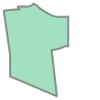

In [9]:
dc.iloc[0]['geometry']

In [10]:
# Set the Coordinate Referance System (crs) for projections
# ESPG code 4326 is also referred to as WGS84 lat-long projection
dc.crs = {'init': 'epsg:4326'}

# Rename columns in geojson map file
dc = dc.rename(columns={'geometry': 'geometry','TRACT':'CENSUS_TRACT'}).set_geometry('geometry')


dc.sort_values(by=['CENSUS_TRACT'])

,OBJECTID,CENSUS_TRACT,GEOID,P0010001,P0010002,P0010003,P0010004,P0010005,P0010006,P0010007,...,FAGI_MED_1,FAGI_TOT_2,FAGI_MED_2,FAGI_TOT_3,FAGI_MED_3,FAGI_TOT_4,FAGI_MED_4,FAGI_TOT_5,FAGI_MED_5,geometry
10,11,000100,11001000100,4890,4808,4444,105,9,201,2,...,86101.5,563927063.0,88250.0,806141206.0,92634.0,8.562673e+08,108308.0,698565228.0,110944.5,"POLYGON ((-77.06475 38.91917, -77.06383 38.918..."
11,12,000201,11001000201,3916,3736,2940,259,7,482,5,...,23000.0,NaN,NaN,282896.0,21739.5,1.389012e+06,5087.0,1043062.0,8785.0,"POLYGON ((-77.07412 38.91259, -77.07394 38.912..."
12,13,000202,11001000202,5425,5294,4705,159,5,375,3,...,95033.5,365051633.0,109460.5,390987146.0,106470.0,4.336313e+08,114630.0,429158437.0,115586.0,"POLYGON ((-77.06568 38.91183, -77.06553 38.911..."
13,14,000300,11001000300,6233,6076,5497,139,11,352,1,...,58822.0,356897869.0,58959.5,371428724.0,61936.5,3.226475e+08,73252.0,358002514.0,70413.0,"POLYGON ((-77.08072 38.92256, -77.08001 38.922..."
14,15,000400,11001000400,1455,1428,1247,50,2,103,0,...,110621.0,224772922.0,101766.0,221418072.0,102512.0,2.604505e+08,130923.5,296162003.0,121711.0,"POLYGON ((-77.06639 38.92753, -77.06606 38.927..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,153,010700,11001010700,1838,1775,1442,89,6,209,0,...,63057.0,65155219.0,58724.0,148356514.0,60245.0,1.318952e+08,71866.0,156457298.0,72231.0,"POLYGON ((-77.04168 38.90904, -77.03994 38.908..."
153,154,010800,11001010800,6408,6194,5146,279,2,708,3,...,42735.0,33571416.0,40108.0,44924794.0,39390.0,3.364005e+07,41873.0,38436301.0,47991.5,"POLYGON ((-77.03946 38.89630, -77.03946 38.895..."
154,155,010900,11001010900,3211,3146,58,3055,6,15,0,...,20753.5,23779752.0,21350.0,25906312.0,20502.0,2.712932e+07,20661.0,27893573.0,21980.0,"POLYGON ((-77.00600 38.82410, -77.00591 38.824..."
155,156,011000,11001011000,3715,3584,1632,1712,29,140,3,...,66090.0,159085656.0,61805.0,167859350.0,64116.0,1.731170e+08,67450.0,184361322.0,70438.5,"POLYGON ((-77.01675 38.87647, -77.01620 38.876..."


In [11]:
neighborhood_data.index = neighborhood_data.index.astype(int)
dc.CENSUS_TRACT = dc.CENSUS_TRACT.astype(int)


              YR_RMDL   ASSESSMENT_NBHD  PRICE_count  PRICE_mean  \
CENSUS_TRACT                                                       
1901               20        Brightwood            1      335000   
6700             1880        Old City 1            1      570000   
6900             1900        Old City 1            1      530000   
4600             1900        Old City 2            1      300000   
9804             1910  Congress Heights            1      330000   
...               ...               ...          ...         ...   
9505             2018       Takoma Park            1      490000   
1200             2018         Wakefield            1     1500000   
9400             2018         Woodridge            2      323450   
11100            2018         Woodridge            5      456000   
9509             2019        Riggs Park            1      564950   

              PRICE_median  LANDAREA_mean  price_sf_mean  
CENSUS_TRACT                                            

In [16]:
# Create a function the returns json_data for the year selected by the user
def json_data(selectedYear):
    yr = selectedYear
    
    # Pull selected year from neighborhood summary data
    df_yr = neighborhood_data[neighborhood_data['YR_RMDL'] == yr]
    
    # Merge the GeoDataframe object (dc) with the neighborhood summary data (neighborhood)
    merged = pd.merge(dc, df_yr, on='CENSUS_TRACT', how='left')
    
#     # Fill the null values
#     values = {'year': yr, 'sale_price_count': 0, 'sale_price_mean': 0, 'sale_price_median': 0,
#               'sf_mean': 0, 'price_sf_mean': 0, 'min_income': 0}
#     merged = merged.fillna(value=values)
    
    # Bokeh uses geojson formatting, representing geographical features, with json
    # Convert to json
    merged_json = json.loads(merged.to_json())
    
    # Convert to json preferred string-like object 
    json_data = json.dumps(merged_json)
    return json_data

In [17]:
# This dictionary contains the formatting for the data in the plots
format_data = [('PRICE_count', 0, 100,'0,0', 'Number of Sales'),
               ('PRICE_mean', 500000, 4000000,'$0,0', 'Average Sales Price'),
               ('PRICE_median', 500000, 4000000, '$0,0', 'Median Sales Price'),
               ('LANDAREA_mean', 500, 5000,'0,0', 'Average Square Footage'),
               ('price_sf_mean', 0, 2000,'$0,0', 'Average Price Per Square Foot')]
 
#Create a DataFrame object from the dictionary 
format_df = pd.DataFrame(format_data, columns = ['field' , 'min_range', 'max_range' , 'format', 'verbage'])

In [18]:
# Define the callback function: update_plot
def update_plot(attr, old, new):
    # The input yr is the year selected from the slider
    yr = slider.value
    new_data = json_data(yr)
    
    # The input cr is the criteria selected from the select box
    cr = select.value
    input_field = format_df.loc[format_df['verbage'] == cr, 'field'].iloc[0]
    
    # Update the plot based on the changed inputs
    p = make_plot(input_field)
    
    # Update the layout, clear the old document and display the new document
    layout = column(p, widgetbox(select), widgetbox(slider))
    curdoc().clear()
    curdoc().add_root(layout)
    
    # Update the data
    geosource.geojson = new_data

In [19]:
# Create a plotting function
def make_plot(field_name):    
    # Set the format of the colorbar
    min_range = format_df.loc[format_df['field'] == field_name, 'min_range'].iloc[0]
    max_range = format_df.loc[format_df['field'] == field_name, 'max_range'].iloc[0]
    field_format = format_df.loc[format_df['field'] == field_name, 'format'].iloc[0]

    # Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
    color_mapper = LinearColorMapper(palette = palette, low = min_range, high = max_range)

    # Create color bar.
    format_tick = NumeralTickFormatter(format=field_format)
    color_bar = ColorBar(color_mapper=color_mapper, label_standoff=18, formatter=format_tick,
    border_line_color=None, location = (0, 0))

    # Create figure object.
    verbage = format_df.loc[format_df['field'] == field_name, 'verbage'].iloc[0]

    p = figure(title = verbage + ' by Neighborhood for Homes in DC by Year remodelled', 
             plot_height = 650, plot_width = 850,
             toolbar_location = None)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.visible = False

    # Add patch renderer to figure. 
    p.patches('xs','ys', source = geosource, fill_color = {'field' : field_name, 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

    # Specify color bar layout.
    p.add_layout(color_bar, 'right')

    # Add the hover tool to the graph
    p.add_tools(hover)
    return p

In [21]:
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application

In [25]:
# Input geojson source that contains features for plotting for:
# initial year 2018 and initial criteria sale_price_median
geosource = GeoJSONDataSource(geojson = json_data(2002))
input_field = 'PRICE_median'

# Define a sequential multi-hue color palette.
palette = brewer['Blues'][8]

# Reverse color order so that dark blue is highest obesity.
palette = palette[::-1]

# Add hover tool
hover = HoverTool(tooltips = [ ('Census tract','@CENSUS_TRACT'),
                               ('# Sales', '@PRICE_count'),
                               ('Average Price', '$@PRICE_mean{,}'),
                               ('Median Price', '$@PRICE_median{,}'),
                               ('Average landarea', '@LANDAREA_mean{,}'),
                               ('Price/SF ', '$@price_sf_mean{,}')])

# Call the plotting function
p = make_plot(input_field)

# Make a slider object: slider 
slider = Slider(title = 'Year',start = 2000, end = 2018, step = 1, value = 2002)
slider.on_change('value', update_plot)

# Make a selection object: select
select = Select(title='Select Criteria:', value='Median Sales Price', options=['Median Sales Price', 'Average Sales Price',
                                                                               'Average Price Per Square Foot',
                                                                               'Average Square Footage', 'Number of Sales'])
select.on_change('value', update_plot)

# Make a column layout of widgetbox(slider) and plot, and add it to the current document
# Display the current document
layout = column(p, widgetbox(select), widgetbox(slider))
curdoc().add_root(layout)


In [29]:
def modify_doc(doc):
    
    # Create a function the returns json_data for the year selected by the user
    def json_data(selectedYear):
        yr = selectedYear

        # Pull selected year from neighborhood summary data
        df_yr = neighborhood_data[neighborhood_data['YR_RMDL'] == yr]

        # Merge the GeoDataframe object (dc) with the neighborhood summary data (neighborhood)
        merged = pd.merge(dc, df_yr, on='CENSUS_TRACT', how='left')

    #     # Fill the null values
    #     values = {'year': yr, 'sale_price_count': 0, 'sale_price_mean': 0, 'sale_price_median': 0,
    #               'sf_mean': 0, 'price_sf_mean': 0, 'min_income': 0}
    #     merged = merged.fillna(value=values)

        # Bokeh uses geojson formatting, representing geographical features, with json
        # Convert to json
        merged_json = json.loads(merged.to_json())

        # Convert to json preferred string-like object 
        json_data = json.dumps(merged_json)
        return json_data
    
    def style(p):
        # Title 
        p.title.align = 'center'
        p.title.text_font_size = '20pt'
        p.title.text_font = 'serif'

        # Axis titles
        p.xaxis.axis_label_text_font_size = '14pt'
        p.xaxis.axis_label_text_font_style = 'bold'
        p.yaxis.axis_label_text_font_size = '14pt'
        p.yaxis.axis_label_text_font_style = 'bold'

        # Tick labels
        p.xaxis.major_label_text_font_size = '12pt'
        p.yaxis.major_label_text_font_size = '12pt'

        return p
    
    # Create a plotting function
    def make_plot(field_name):    
        # Set the format of the colorbar
        min_range = format_df.loc[format_df['field'] == field_name, 'min_range'].iloc[0]
        max_range = format_df.loc[format_df['field'] == field_name, 'max_range'].iloc[0]
        field_format = format_df.loc[format_df['field'] == field_name, 'format'].iloc[0]

        # Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
        color_mapper = LinearColorMapper(palette = palette, low = min_range, high = max_range)

        # Create color bar.
        format_tick = NumeralTickFormatter(format=field_format)
        color_bar = ColorBar(color_mapper=color_mapper, label_standoff=18, formatter=format_tick,
        border_line_color=None, location = (0, 0))

        # Create figure object.
        verbage = format_df.loc[format_df['field'] == field_name, 'verbage'].iloc[0]

        p = figure(title = verbage + ' by Neighborhood for Homes in DC by Year remodelled', 
                 plot_height = 650, plot_width = 850,
                 toolbar_location = None)
        p.xgrid.grid_line_color = None
        p.ygrid.grid_line_color = None
        p.axis.visible = False

        # Add patch renderer to figure. 
        p.patches('xs','ys', source = geosource, fill_color = {'field' : field_name, 'transform' : color_mapper},
              line_color = 'black', line_width = 0.25, fill_alpha = 1)

        # Specify color bar layout.
        p.add_layout(color_bar, 'right')

        # Add the hover tool to the graph
        p.add_tools(hover)
        return p
    
    # Define the callback function: update_plot
    def update_plot(attr, old, new):
        # The input yr is the year selected from the slider
        yr = slider.value
        new_data = json_data(yr)

        # The input cr is the criteria selected from the select box
        cr = select.value
        input_field = format_df.loc[format_df['verbage'] == cr, 'field'].iloc[0]

        # Update the plot based on the changed inputs
        p = make_plot(input_field)

        # Update the layout, clear the old document and display the new document
        layout = column(p, widgetbox(select), widgetbox(slider))
        curdoc().clear()
        curdoc().add_root(layout)

        # Update the data
        geosource.geojson = new_data
        
    # Input geojson source that contains features for plotting for:
    # initial year 2018 and initial criteria sale_price_median
    geosource = GeoJSONDataSource(geojson = json_data(2002))
    input_field = 'PRICE_median'

    # Define a sequential multi-hue color palette.
    palette = brewer['Blues'][8]

    # Reverse color order so that dark blue is highest obesity.
    palette = palette[::-1]

    # Add hover tool
    hover = HoverTool(tooltips = [ ('Census tract','@CENSUS_TRACT'),
                                   ('# Sales', '@PRICE_count'),
                                   ('Average Price', '$@PRICE_mean{,}'),
                                   ('Median Price', '$@PRICE_median{,}'),
                                   ('Average landarea', '@LANDAREA_mean{,}'),
                                   ('Price/SF ', '$@price_sf_mean{,}')])

    # Call the plotting function
    p = make_plot(input_field)

    # Make a slider object: slider 
    slider = Slider(title = 'Year',start = 2000, end = 2018, step = 1, value = 2002)
    slider.on_change('value', update_plot)

    # Make a selection object: select
    select = Select(title='Select Criteria:', value='Median Sales Price', options=['Median Sales Price', 'Average Sales Price',
                                                                                   'Average Price Per Square Foot',
                                                                                   'Average Square Footage', 'Number of Sales'])
    select.on_change('value', update_plot)

    # Make a column layout of widgetbox(slider) and plot, and add it to the current document
    # Display the current document
    layout = column(p, widgetbox(select), widgetbox(slider))

    # Make a tab with the layout 
    tab = Panel(child=layout, title = 'Map')
    tabs = Tabs(tabs=[tab])
    
    doc.add_root(tabs)
    
# Set up an application
handler = FunctionHandler(modify_doc)
app = Application(handler)